In [71]:
import pandas as pd; import geopandas as gpd
import seaborn as sns
import json, sys, os
from datetime import datetime, date

from matplotlib.ticker import FuncFormatter
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Use AWS Athena to get the data:

```sql
WITH changesets_as_points AS (
  SELECT 
    id as _id,
    uid as _uid,
    num_changes as _edits,
    ST_POINT(min_lon, min_lat) as corner,
    date_trunc('week', created_at) as _week,
    tags['hashtags'] like '%hotosm%' as _hot
  FROM changesets
  WHERE created_at > date '2010-01-01'
)
SELECT 
  count(_id) as changesets,
  histogram(_hot) as hot_or_not,
  histogram(_uid)  as users_hist, 
  sum(_edits) as total_changes,
  _week as week, 
  su_a3 as a3

FROM changesets_as_points JOIN countries ON ST_CONTAINS(ST_GeometryFromText(wkt), corner)

WHERE tol < 0.11 AND tol > 0.09
  AND subregion like 'Central America'
  GROUP BY _week, su_a3
```

In [72]:
# Output of above query is saved as central_america_changesets.csv
df = pd.read_csv('./data/central_america_changesets.csv')
print("Read {:,} changesets".format(len(df)))
# Parse and add a few fields
df['week'] = df.week.apply(lambda d: pd.Timestamp(d).date())
df['year'] = df.week.apply(lambda d: d.year)
df.head(2)

Read 4,503 changesets


,changesets,hot_or_not,users_hist,total_changes,week,a3,year
0,84,"{false=52, true=2}","{9395917=35, 1621340=19, 250487=5, 12081501=1,...",4550,2020-10-26,NIC,2020
1,142,{false=1},"{11148747=1, 3290160=2, 11143881=3, 6815820=1,...",4277,2020-05-04,CRI,2020


In [73]:
import re
hot_regex = re.compile('true=(\d+)')
not_hot_regex = re.compile('false=(\d+)')
df['hot_changesets'] = df.hot_or_not.apply(lambda s: hot_regex.findall(s) if type(s)==str else None).apply(lambda x: int(x[0]) if type(x)==list and len(x)>0 else None)
df['not_hot_changesets'] = df.hot_or_not.apply(lambda s: not_hot_regex.findall(s) if type(s)==str else None).apply(lambda x: int(x[0]) if type(x)==list and len(x)>0 else None)

In [74]:
uids = re.compile('(\d+)=\d+')
df['uids'] = df.users_hist.apply(lambda s: set(uids.findall(s)))
df['u_count'] = df.uids.apply(len)

In [75]:
df.head(2)

,changesets,hot_or_not,users_hist,total_changes,week,a3,year,hot_changesets,not_hot_changesets,uids,u_count
0,84,"{false=52, true=2}","{9395917=35, 1621340=19, 250487=5, 12081501=1,...",4550,2020-10-26,NIC,2020,2.0,52.0,"{250487, 109705, 10019169, 9395917, 12074931, ...",9
1,142,{false=1},"{11148747=1, 3290160=2, 11143881=3, 6815820=1,...",4277,2020-05-04,CRI,2020,NaN,1.0,"{10228232, 86865, 11127289, 4693111, 3290160, ...",19


In [76]:
# Also read Countries
countries_raw = gpd.read_file('./data/countries.geojson')
df = df.merge(countries_raw.rename(columns={"SU_A3":'a3'})[['ADMIN','CONTINENT','a3','geometry','POP_EST']])
df.head(2)

,changesets,hot_or_not,users_hist,total_changes,week,a3,year,hot_changesets,not_hot_changesets,uids,u_count,ADMIN,CONTINENT,geometry,POP_EST
0,84,"{false=52, true=2}","{9395917=35, 1621340=19, 250487=5, 12081501=1,...",4550,2020-10-26,NIC,2020,2.0,52.0,"{250487, 109705, 10019169, 9395917, 12074931, ...",9,Nicaragua,North America,"MULTIPOLYGON (((-85.70174 11.08088, -85.70242 ...",6025951
1,42,NaN,"{4115486=3, 5587605=1, 19488=2, 5284821=1, 241...",201,2017-03-27,NIC,2017,NaN,NaN,"{225842, 5065983, 19488, 2413418, 5593768, 378...",16,Nicaragua,North America,"MULTIPOLYGON (((-85.70174 11.08088, -85.70242 ...",6025951


## 1. How many mappers are active in Central America?

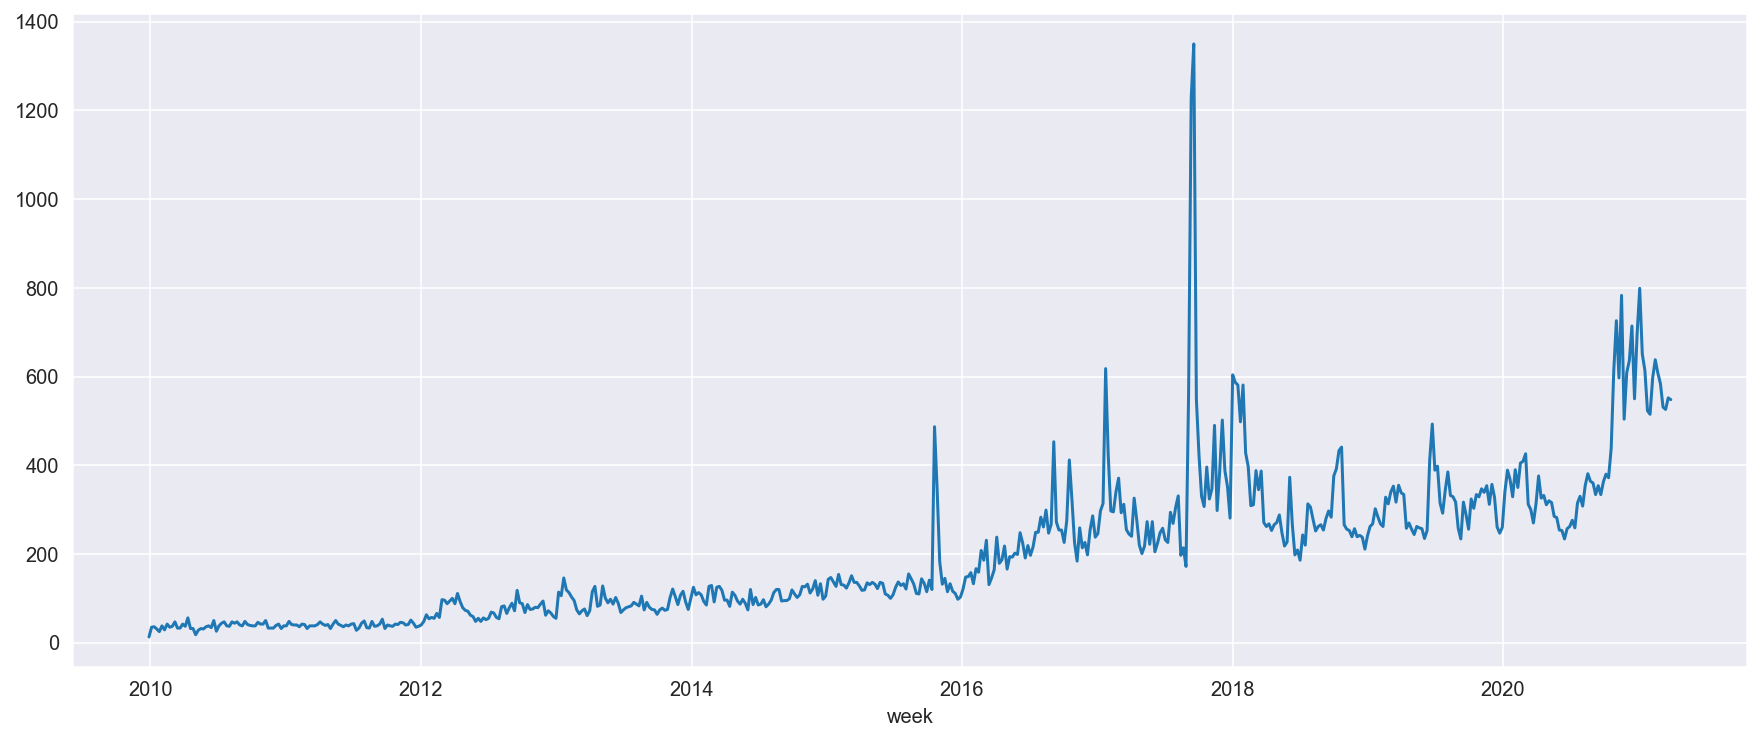

In [77]:
tmp = df.groupby('week').aggregate({'changesets':sum,'uids':lambda x: set.union(*x)})
tmp['u_count'] = tmp.uids.apply(len)
ax = tmp.u_count.plot(figsize=(15,6))

Text(0.5, 1.0, 'Users active since 2010 in Central America')

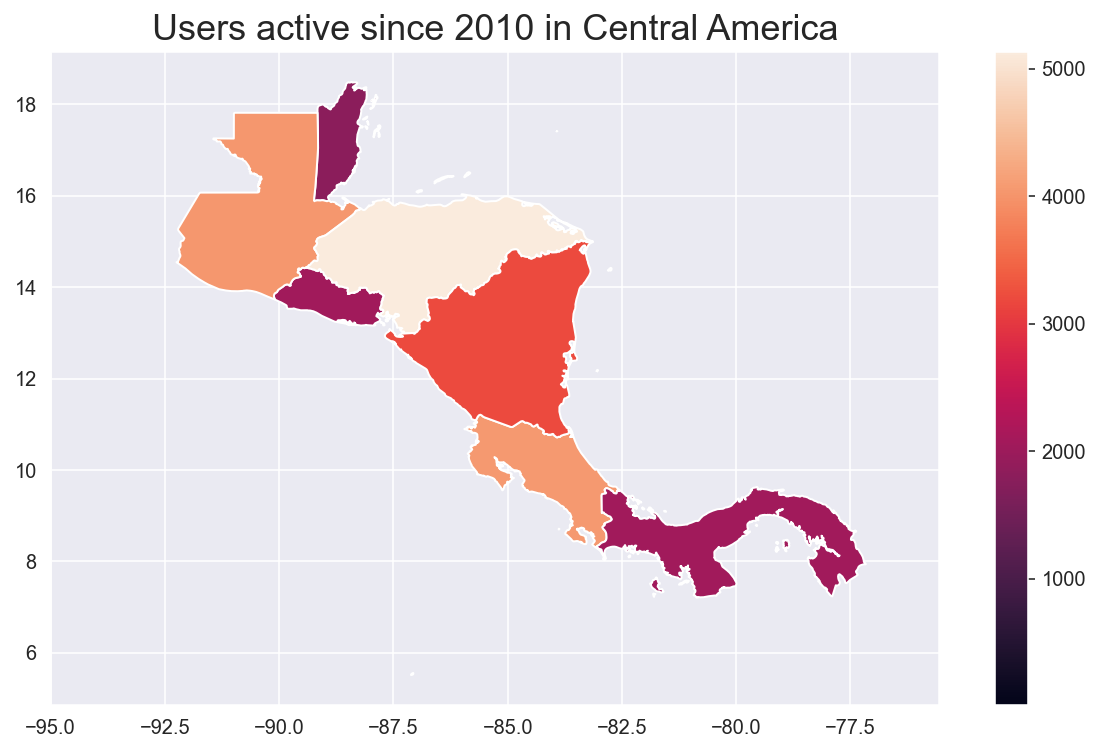

In [78]:
tmp = df[df.ADMIN!='Mexico'].groupby('ADMIN').aggregate(
    {'changesets':sum,'uids':lambda x: set.union(*x),'geometry':'first'})
tmp['u_count'] = tmp.uids.apply(len)
ax = gpd.GeoDataFrame(tmp).plot(figsize=(10,6), column='u_count',legend=True)
ax.set_xlim(-95)
ax.set_title("Users active since 2010 in Central America", fontsize=18)

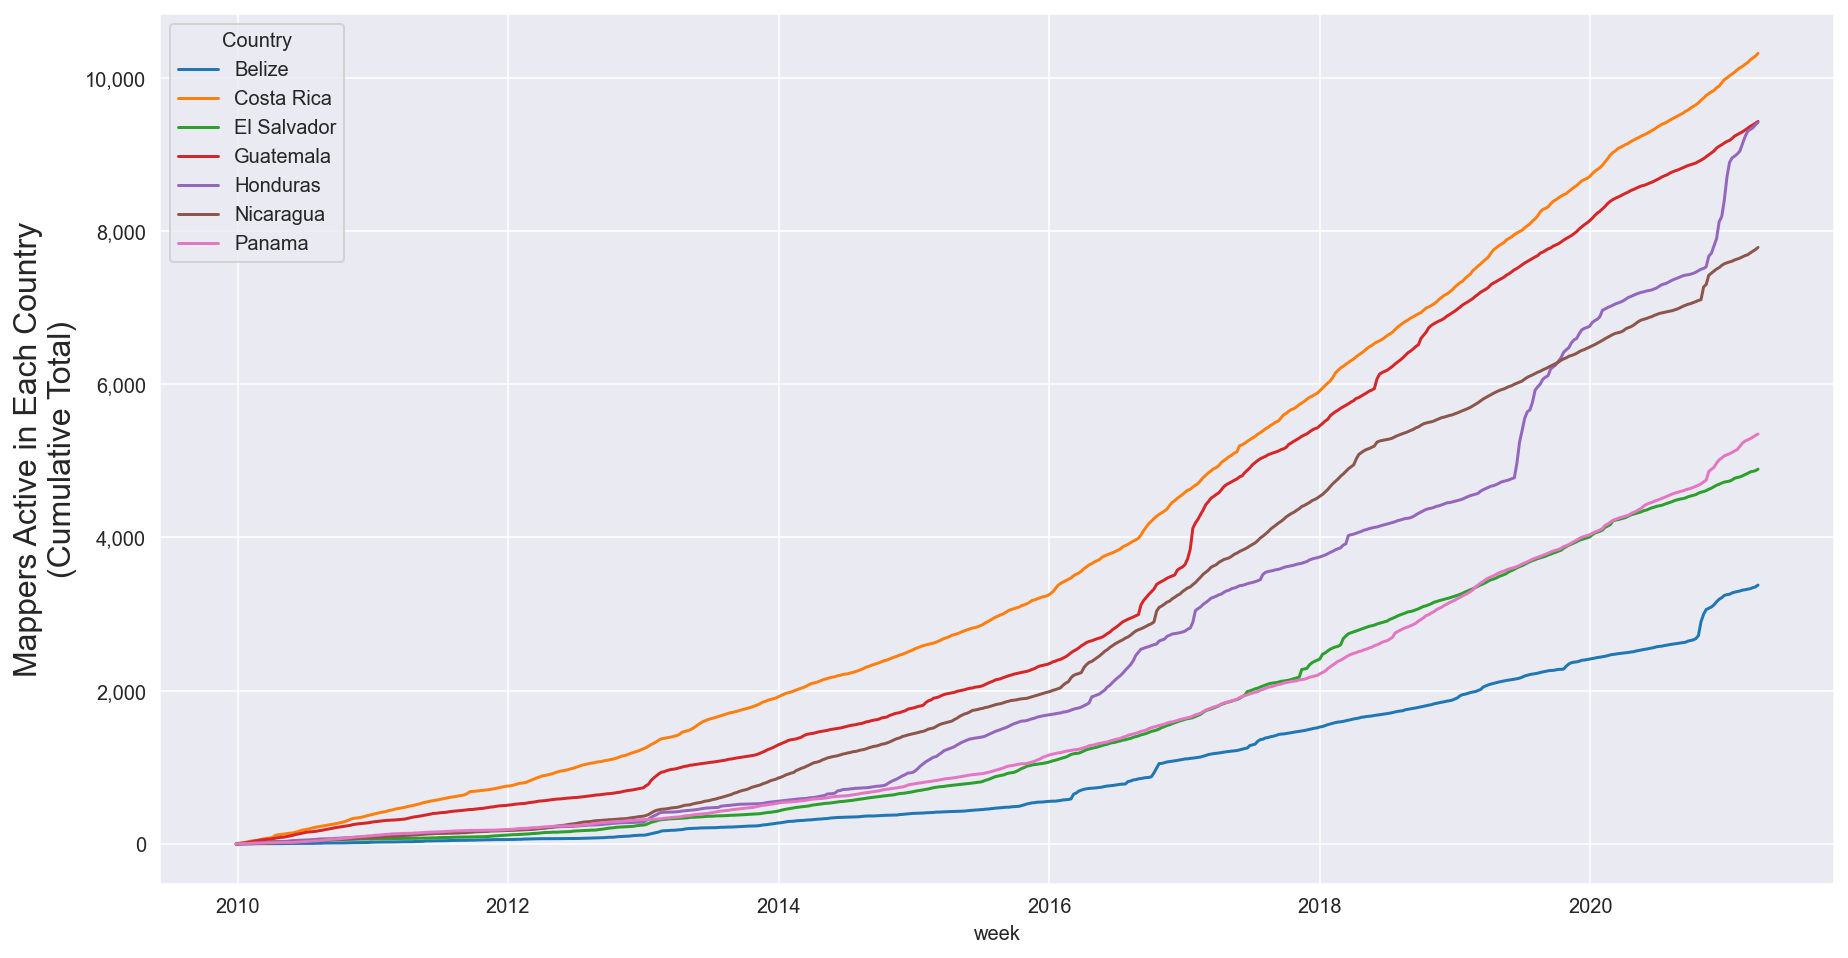

In [110]:
tmp = df[(df.ADMIN!='Mexico') & (df.ADMIN!='Clipperton Island')].groupby(['week','ADMIN']).aggregate(
    {'changesets':sum,
     'uids':lambda x: set.union(*x)})
tmp['u_count'] = tmp.uids.apply(len)
tmp = tmp.unstack().fillna(0)
ax = tmp['u_count'].cumsum().plot(figsize=(15,8))
ax.legend(title="Country")
ax.set_ylabel("Mappers Active in Each Country\n(Cumulative Total)", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))));

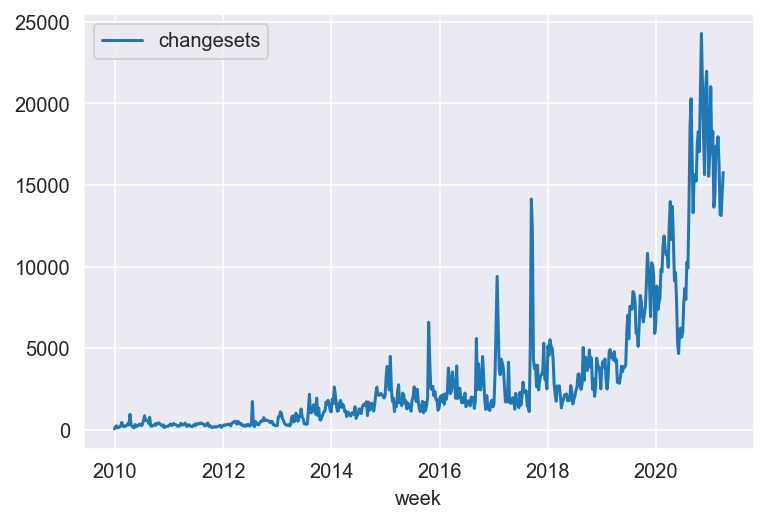

In [50]:
sns.set_style("darkgrid")
ax = df.groupby('week').aggregate(
    {'changesets':sum}).plot()

Text(0.5, 0, '')

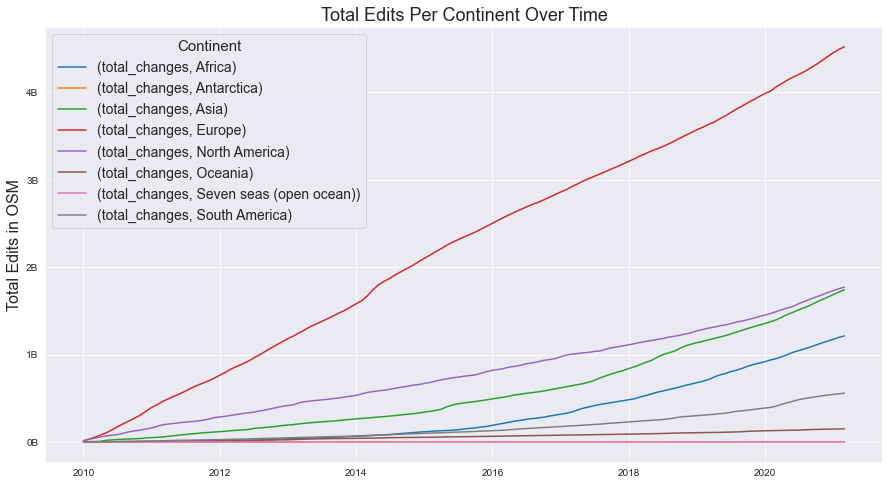

In [139]:
ax = df.groupby(['month','CONTINENT']).aggregate({'total_changes':sum}).unstack().cumsum().plot(figsize=(15,8))
ax.set_title("Total Edits Per Continent Over Time", fontsize=18)
ax.set_ylabel("Total Edits in OSM", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}B".format(int(x/1000000000))))
ax.legend(title="Continent", fontsize=14, title_fontsize=15)
ax.set_xlabel(None)

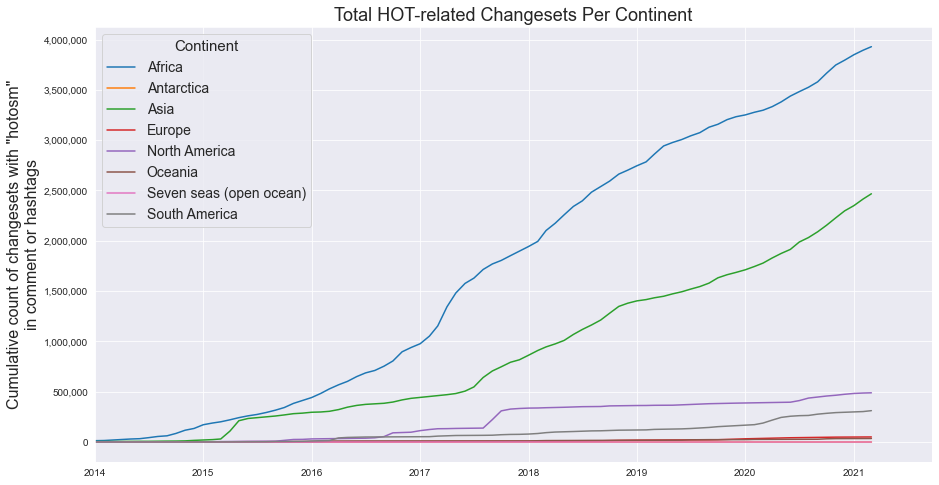

In [140]:
ax = df.groupby(['month','CONTINENT']).aggregate({'hot_changesets':sum}).unstack().cumsum().plot(figsize=(15,8))
ax.set_title("Total HOT-related Changesets Per Continent", fontsize=18)
ax.set_ylabel('Cumulative count of changesets with "hotosm"\nin comment or hashtags', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:,}".format(int(x))))
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=[re.compile(', (.*)\)').findall(t)[0] for t in labels],
    title="Continent", fontsize=14, title_fontsize=15)
ax.set_xlabel(None); ax.set_xlim(date(2014,1,1));

<AxesSubplot:xlabel='CONTINENT'>

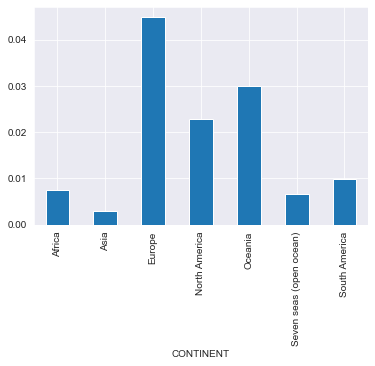

In [160]:
# Edits per country based on population? 
gb_continent = df[df.CONTINENT != "Antarctica"].groupby('CONTINENT').aggregate(
    {'POP_EST':sum,'total_changes':sum, 'changesets':sum})
(gb_continent.total_changes / gb_continent.POP_EST).plot.bar()

In [ ]:
ax.

In [30]:
sns.set_style('darkgrid')
ax = df.groupby('date').aggregate({'uid':'nunique'}).rolling(7).mean().plot(figsize=(15,8), legend=None)

# ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{}))
ax.set_title("Number of Daily Mappers active in Africa", fontsize=18);
ax.set_ylabel("Daily Mappers (7 Day rolling average)")
ax.set_xlabel("Date")

KeyError: 'date'

## 2. Mappers Active Per Country, Per Year?

In [88]:
order = df.groupby('country').aggregate({'num_changes':'sum'}).sort_values(by='num_changes',ascending=False).reindex().index

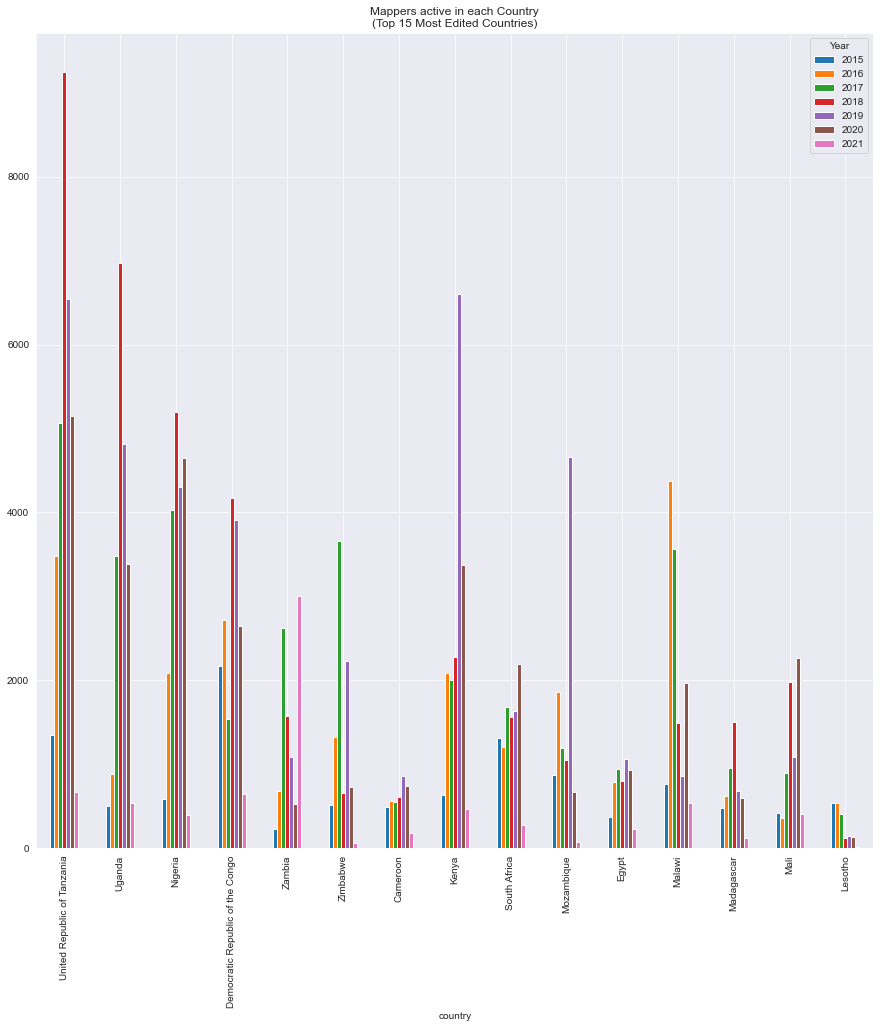

In [90]:
ax = df.groupby(['country','year']).aggregate(
    {'uid':pd.Series.nunique}
#     {'changeset':'count'}
).unstack().loc[order[:15]].plot.bar(figsize=(15,15), stacked=False)
ax.set_title("Mappers active in each Country\n(Top 15 Most Edited Countries)")
ax.legend([2015,2016,2017,2018,2019,2020,2021], title="Year")

Text(0.5, 0, '')

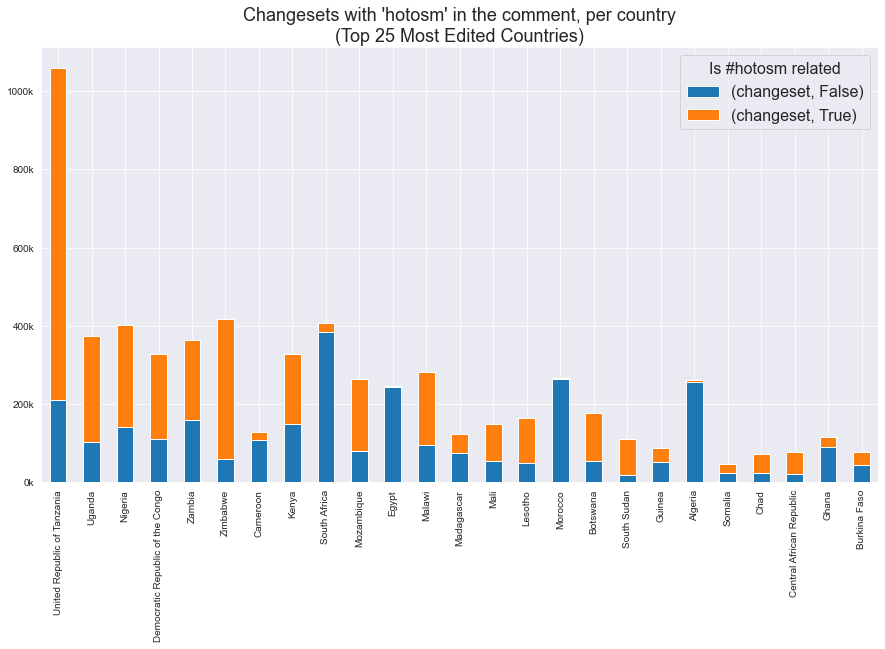

In [100]:
ax = df.groupby(['country','hot']).aggregate(
    {'changeset':pd.Series.count}
#     {'changeset':'count'}
).unstack().loc[order[:25]].plot.bar(figsize=(15,8), stacked=True)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{}k".format(int(x/1000))))
ax.legend(title="Is #hotosm related", fontsize=16, title_fontsize=16)
ax.set_title("Changesets with 'hotosm' in the comment, per country\n(Top 25 Most Edited Countries)", fontsize=18)
ax.set_xlabel(None)

In [101]:
df.head()

,changeset,uid,user,created_at,corner,num_changes,_comment,hashtags,country,A3,continent,tol,date,year,hot
0,69031119,9320655,Tchoupitoulas,2019-04-09 06:10:06.000,POINT (33.4413528 -13.5872962),33,Aligned residential highways according to Bing...,NaN,Malawi,MWI,Africa,0.1,2019-04-09,2019,False
1,69031122,8847254,Roméo,2019-04-09 06:10:11.000,POINT (47.7571543 -21.174552),40,#hotosm-project-4408 #IRD_FR #PIVOTMadagascar ...,#hotosm-project-4408;#IRD_FR;#PIVOTMadagascar,Madagascar,MDG,Africa,0.1,2019-04-09,2019,True
2,69031129,9225258,PlazaBaquedano,2019-04-09 06:10:33.000,POINT (34.0473314 -14.4812418),4,Changed the classification from residential to...,NaN,Mozambique,MOZ,Africa,0.1,2019-04-09,2019,False
3,69031131,9405390,SSannerFSU,2019-04-09 06:10:35.000,POINT (13.213774 12.4922245),23,#hotosm-project-5700 #missingmaps #lakechad #n...,#hotosm-project-5700;#missingmaps;#lakechad;#n...,Nigeria,NGA,Africa,0.1,2019-04-09,2019,True
4,69031136,172099,Biker69,2019-04-09 06:10:57.000,POINT (25.6388892 -20.9413892),256,modified,NaN,Botswana,BWA,Africa,0.1,2019-04-09,2019,False


In [102]:
df['apple'] = df._comment.apply(lambda _string: '#adt' in _string if type(_string)==str else False)

Text(0.5, 0, '')

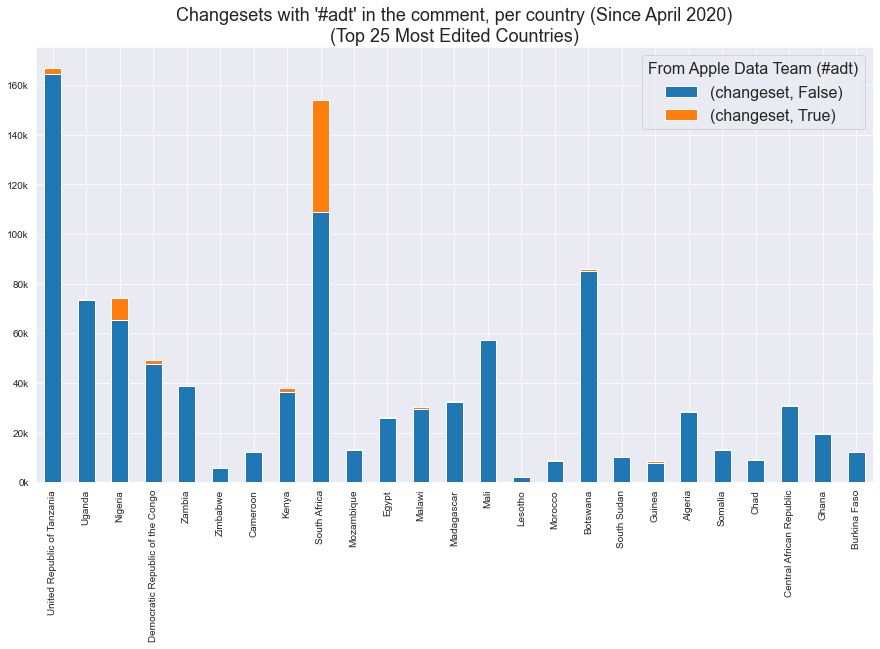

In [110]:
ax = df[df.date > date(2020,4,1)].groupby(['country','apple']).aggregate(
    {'changeset':pd.Series.count}
#     {'changeset':'count'}
).unstack().loc[order[:25]].plot.bar(figsize=(15,8), stacked=True)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{}k".format(int(x/1000))))
ax.legend(title="From Apple Data Team (#adt)", fontsize=16, title_fontsize=16)
ax.set_title("Changesets with '#adt' in the comment, per country (Since April 2020)\n(Top 25 Most Edited Countries)", fontsize=18)
ax.set_xlabel(None)

In [115]:
df.groupby(['country','year','hot']).aggregate({'num_changes':'sum','changeset':'count','uid':pd.Series.nunique})



num_changes  changeset   uid
country  year hot                                
Algeria  2015 False      3087836      62428   734
              True          2864         28    12
         2016 False      2768549      53561  2609
              True          2679         17     6
         2017 False      1784264      35135  2860
...                          ...        ...   ...
eSwatini 2019 True         52219        519     5
         2020 False        82374        815   128
              True          4148         54     9
         2021 False        20697        149    25
              True           348          8     3

[718 rows x 3 columns]

### Write Out Per Country Stats Since 2015

In [136]:
per_country_counts = df.groupby('country').aggregate({'num_changes':'sum','changeset':'count','uid':pd.Series.nunique}).rename(columns={
    'num_changes':"Total OSM Edits Since 2015",'changeset':"Total Changesets Since 2015","uid":"Total Users Since 2015"
})
per_country_counts.to_csv('output/per_country_stats_since_2015.csv')
per_country_counts.sort_values(by='Total Users Since 2015',ascending=False).head()

,Total OSM Edits Since 2015,Total Changesets Since 2015,Total Users Since 2015
country,,,
United Republic of Tanzania,149243536,1058422,27759
Nigeria,78165561,401439,19289
Uganda,79211890,374128,18747
Kenya,41742027,327854,15694
Democratic Republic of the Congo,53994923,327946,15281


In [137]:
per_country_per_year_counts = df.groupby(['country','year']).aggregate({'num_changes':'sum','changeset':'count','uid':pd.Series.nunique}).rename(columns={
    'num_changes':"Total OSM Edits Since 2015",'changeset':"Total Changesets Since 2015","uid":"Total Users Since 2015"
})
# per_country_per_year_counts.to_csv('output/per_country_per_year.csv')
per_country_per_year_counts.head()

Total OSM Edits Since 2015  Total Changesets Since 2015  \
country year                                                            
Algeria 2015                     3090700                        62456   
        2016                     2771228                        53578   
        2017                     1787265                        35149   
        2018                     2750368                        35937   
        2019                     3359677                        35756   

              Total Users Since 2015  
country year                          
Algeria 2015                     744  
        2016                    2614  
        2017                    2872  
        2018                    2094  
        2019                    1336

In [138]:
df.head()

,changeset,uid,user,created_at,corner,num_changes,_comment,hashtags,country,A3,continent,tol,date,year,hot,apple
0,69031119,9320655,Tchoupitoulas,2019-04-09 06:10:06.000,POINT (33.4413528 -13.5872962),33,Aligned residential highways according to Bing...,NaN,Malawi,MWI,Africa,0.1,2019-04-09,2019,False,False
1,69031122,8847254,Roméo,2019-04-09 06:10:11.000,POINT (47.7571543 -21.174552),40,#hotosm-project-4408 #IRD_FR #PIVOTMadagascar ...,#hotosm-project-4408;#IRD_FR;#PIVOTMadagascar,Madagascar,MDG,Africa,0.1,2019-04-09,2019,True,False
2,69031129,9225258,PlazaBaquedano,2019-04-09 06:10:33.000,POINT (34.0473314 -14.4812418),4,Changed the classification from residential to...,NaN,Mozambique,MOZ,Africa,0.1,2019-04-09,2019,False,False
3,69031131,9405390,SSannerFSU,2019-04-09 06:10:35.000,POINT (13.213774 12.4922245),23,#hotosm-project-5700 #missingmaps #lakechad #n...,#hotosm-project-5700;#missingmaps;#lakechad;#n...,Nigeria,NGA,Africa,0.1,2019-04-09,2019,True,False
4,69031136,172099,Biker69,2019-04-09 06:10:57.000,POINT (25.6388892 -20.9413892),256,modified,NaN,Botswana,BWA,Africa,0.1,2019-04-09,2019,False,False


In [141]:
df['ym'] = df._comment.apply(lambda s: 'youthmapper' in s.lower() if type(s)==str else False)

In [150]:
df['gm'] = df._comment.apply(lambda s: 'goodmapper' in s.lower() if type(s)==str else False)

In [153]:
df['lm'] = df._comment.apply(lambda s: 'lionmapper' in s.lower() if type(s)==str else False)

In [154]:
df[df.lm].uid.nunique()

27

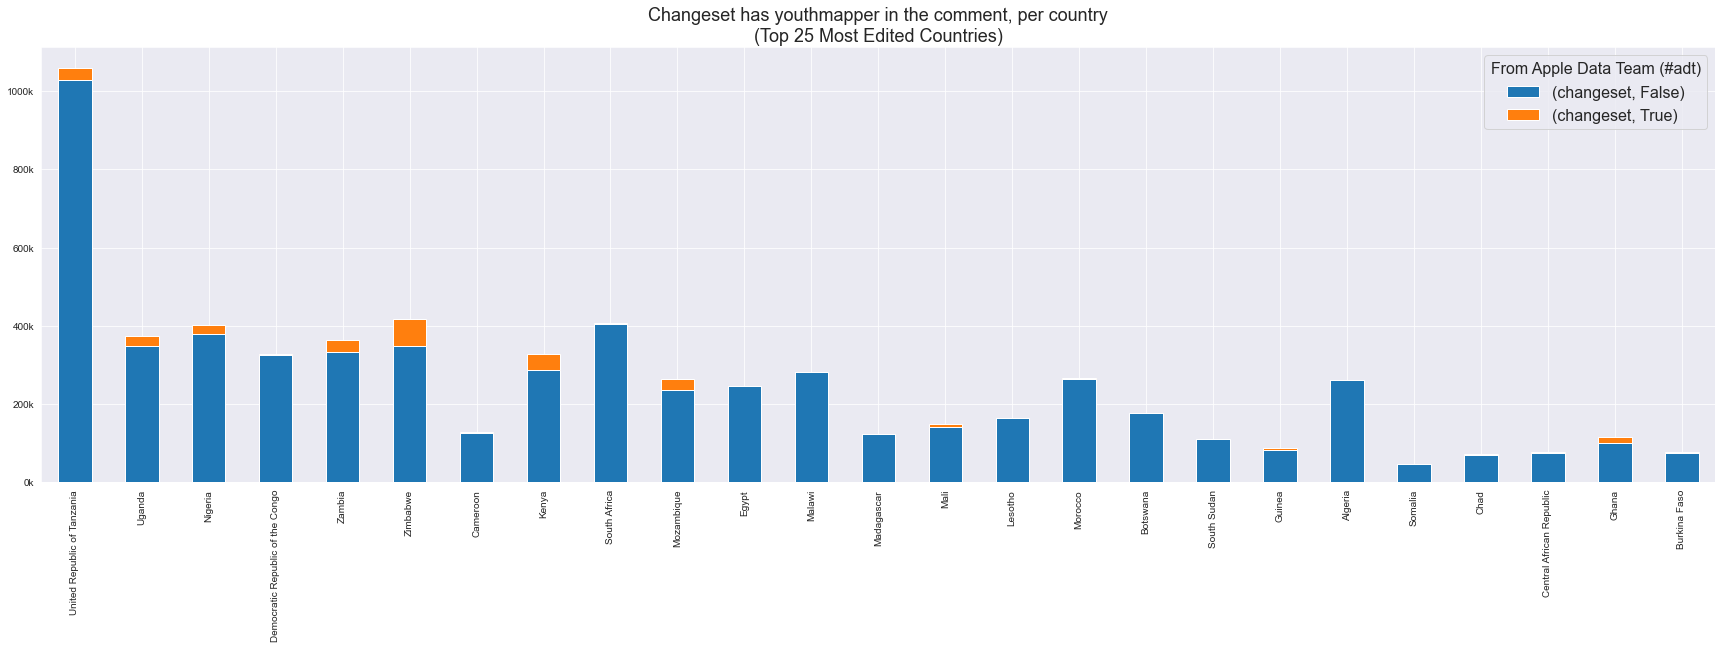

In [177]:
ax = df.groupby(['country','ym']).aggregate(
    {'changeset':pd.Series.count}
#     {'changeset':'count'}
).unstack().loc[order[:25]].plot.bar(figsize=(30,8), stacked=True)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{}k".format(int(x/1000))))
ax.legend(title="From Apple Data Team (#adt)", fontsize=16, title_fontsize=16)
ax.set_title("Changeset has youthmapper in the comment, per country\n(Top 25 Most Edited Countries)", fontsize=18)
ax.set_xlabel(None);

In [159]:
# What's the best way to know if they're YouthMappers or not?!

In [161]:
df.head()

,changeset,uid,user,created_at,corner,num_changes,_comment,hashtags,country,A3,continent,tol,date,year,hot,apple,ym,gm,lm
0,69031119,9320655,Tchoupitoulas,2019-04-09 06:10:06.000,POINT (33.4413528 -13.5872962),33,Aligned residential highways according to Bing...,NaN,Malawi,MWI,Africa,0.1,2019-04-09,2019,False,False,False,False,False
1,69031122,8847254,Roméo,2019-04-09 06:10:11.000,POINT (47.7571543 -21.174552),40,#hotosm-project-4408 #IRD_FR #PIVOTMadagascar ...,#hotosm-project-4408;#IRD_FR;#PIVOTMadagascar,Madagascar,MDG,Africa,0.1,2019-04-09,2019,True,False,False,False,False
2,69031129,9225258,PlazaBaquedano,2019-04-09 06:10:33.000,POINT (34.0473314 -14.4812418),4,Changed the classification from residential to...,NaN,Mozambique,MOZ,Africa,0.1,2019-04-09,2019,False,False,False,False,False
3,69031131,9405390,SSannerFSU,2019-04-09 06:10:35.000,POINT (13.213774 12.4922245),23,#hotosm-project-5700 #missingmaps #lakechad #n...,#hotosm-project-5700;#missingmaps;#lakechad;#n...,Nigeria,NGA,Africa,0.1,2019-04-09,2019,True,False,False,False,False
4,69031136,172099,Biker69,2019-04-09 06:10:57.000,POINT (25.6388892 -20.9413892),256,modified,NaN,Botswana,BWA,Africa,0.1,2019-04-09,2019,False,False,False,False,False


In [221]:
unames = json.load(open('../youthmappers-analysis/data/userList.json'))
known_uids = set(list(unames.keys()))

In [222]:
df['known_ym'] = df.uid.apply(lambda uid: len( set([str(uid)]) & known_uids)==1)

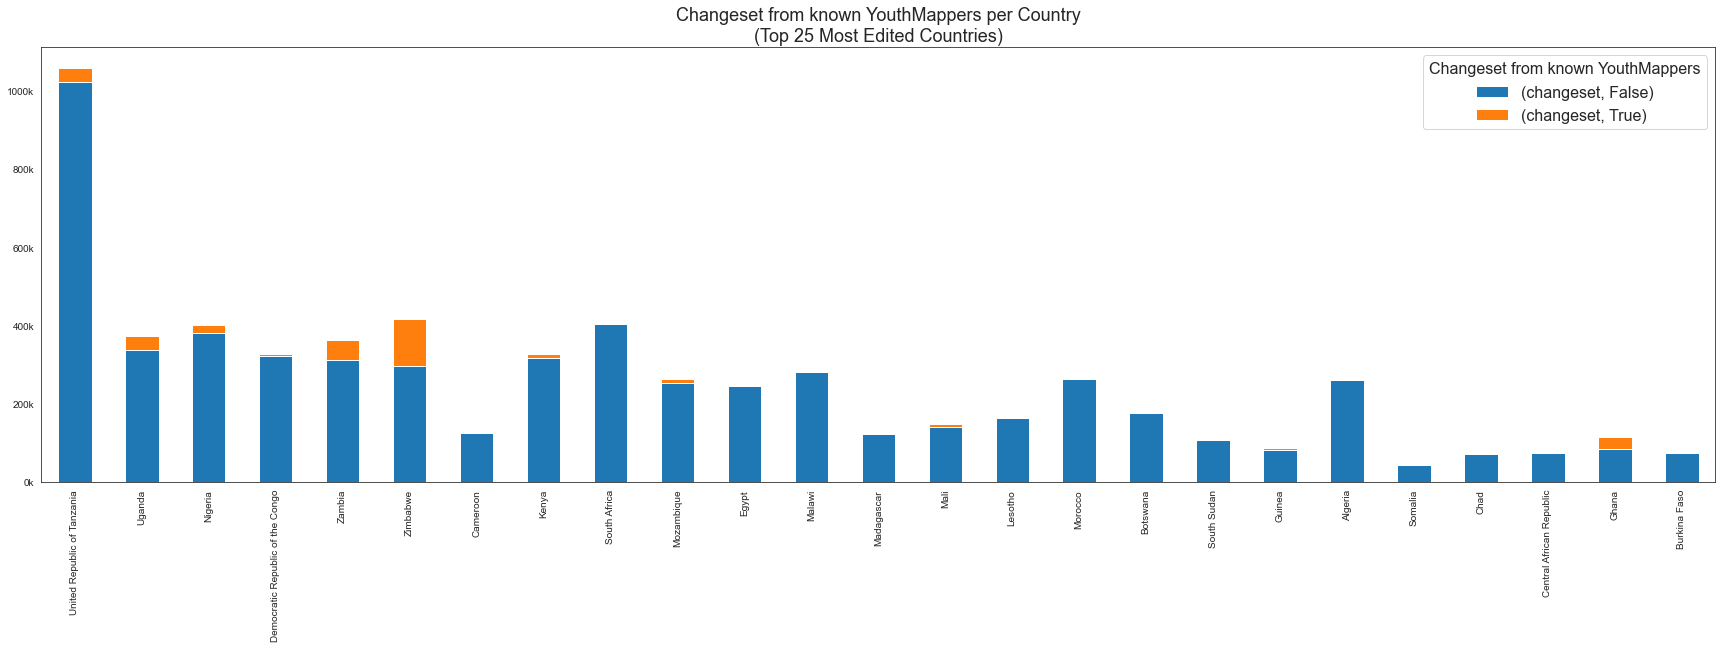

In [223]:
ax = df.groupby(['country','known_ym']).aggregate(
    {'changeset':pd.Series.count}
#     {'changeset':'count'}
).unstack().loc[order[:25]].plot.bar(figsize=(30,8), stacked=True)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{}k".format(int(x/1000))))
ax.legend(title="Changeset from known YouthMappers", fontsize=16, title_fontsize=16)
ax.set_title("Changeset from known YouthMappers per Country\n(Top 25 Most Edited Countries)", fontsize=18)
ax.set_xlabel(None);

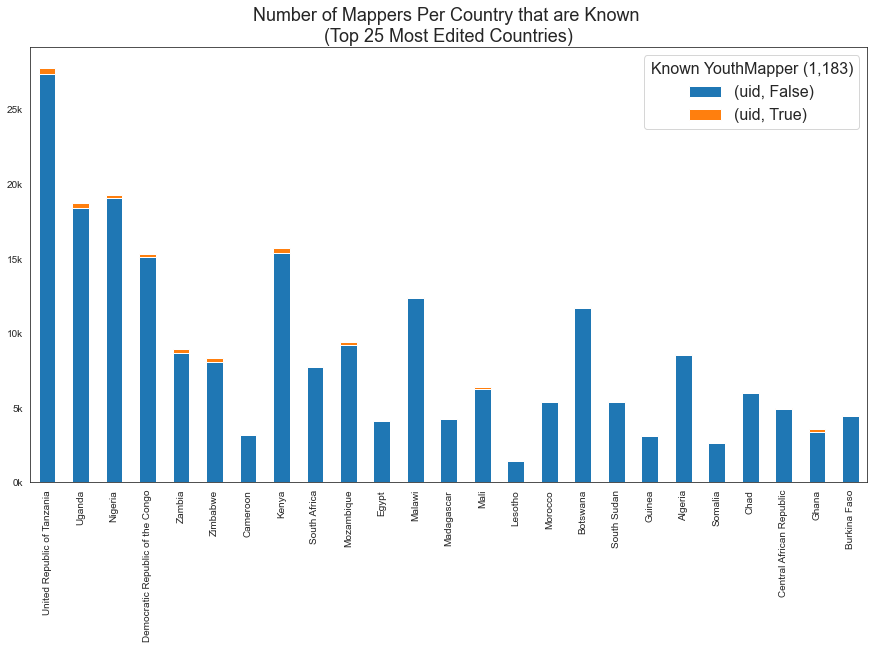

In [236]:
ax = df.groupby(['country','known_ym']).aggregate(
    {'uid':pd.Series.nunique}
).unstack().loc[order[:25]].plot.bar(figsize=(15,8), stacked=True)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "{}k".format(int(x/1000))))
ax.legend(title="Known YouthMapper ({:,})".format(df[df.known_ym].uid.nunique()), fontsize=16, title_fontsize=16)
ax.set_title("Number of Mappers Per Country that are Known \n(Top 25 Most Edited Countries)", fontsize=18)
ax.set_xlabel(None);

In [224]:
from shapely import wkt

In [225]:
youthmappers = pd.DataFrame(df[df.known_ym])
youthmappers['geometry'] = youthmappers.corner.apply(wkt.loads)

In [226]:
ym_edits = gpd.GeoDataFrame( youthmappers ) 

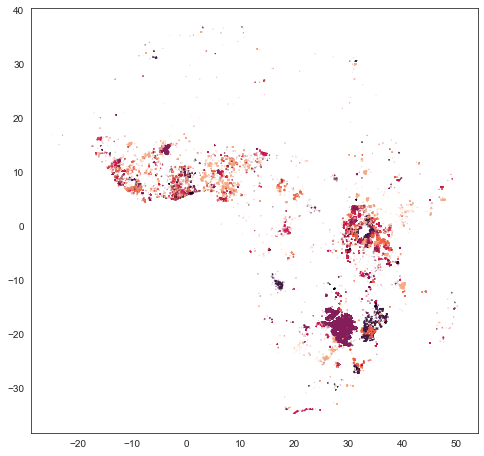

In [227]:
sns.set_style('white')
ax = ym_edits.plot(figsize=(8,12), markersize=0.01, c=ym_edits.year)

In [220]:
len(youthmappers)

354599

In [228]:
len(youthmappers)

366329

1183